<a href="https://colab.research.google.com/github/sushantnair/Reinforcement-Learning-2nd-Edition-Notes-Codes/blob/main/chapter_05_monte_carlo_methods/Monte_Carlo_Blackjack_Demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Dependencies

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 17.3 MB/s eta 0:00:00


# Importing Dependencies

In [ ]:
import random
import numpy as np
import gymnasium as gym
from gym import error, spaces, utils
from gym.utils import seeding
import enum
import pandas as pd
import matplotlib.pyplot as plt
import time

# Set up the game

In [ ]:
# Define the rank and suit of a card

ranks = {
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10,
    "jack": 10,
    "queen": 10,
    "king": 10,
    "ace": (1, 11),
}

class Suit(enum.Enum):
    spades = "spades"
    clubs = "clubs"
    diamonds = "diamonds"
    hearts = "hearts"

# Now to define the card and deck
# Implement the shuffle, peek and deal functions for the deck

class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value

    def __str__(self):
        return self.rank + " of " + self.suit.value

class Deck:
    def __init__(self, num=1):
        self.cards = []
        for i in range(num):
            for suit in Suit:
                for rank, value in ranks.items():
                    self.cards.append(Card(suit, rank, value))

    def shuffle(self):
        random.shuffle(self.cards)

    def deal(self):
        return self.cards.pop(0)

    def peek(self):
        if len(self.cards) > 0:
            return self.cards[0]

    def add_to_bottom(self, card):
        self.cards.append(card)

    def __str__(self):
        result = ""
        for card in self.cards:
            result += str(card) + "\n"
        return result

    def __len__(self):
        return len(self.cards)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Define the logic for evaluating the value of the player's hand

In [ ]:
'''
An ace is used as 11 whenever possible. It is 1 only if the other option would make the player bust.
'''

def player_eval(player_hand):
    num_ace = 0
    # use_one means that every ace in the hand is counted as one
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value

    if num_ace > 0:
        # Define player policy for Aces:
        # Make Aces 11 if they get you to the range [18, 21]
        # Otherwise, use one.

        ace_counter = 0
        while ace_counter < num_ace:
            # Only add by 10 because 1 is already added before
            use_eleven = use_one + 10
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 18 and use_eleven <= 21:
                return use_eleven
            else:
                # This allows for some Aces to be 11 and others to be 1.
                use_one = use_eleven
            ace_counter += 1
        return use_one
    else:
        return use_one

# Define the logic for evaluating the value of the dealer's hand

In [ ]:
# This follows the same, official rules every time.
# Still there is a need to figure out what happens if there are multiple Aces.
def dealer_eval(player_hand):
    num_ace = 0
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value

    if num_ace > 0:
        # See if using 11 instead of 1 for the Ace gets the dealer's hand value closer to the [17, 21] range.
        # The dealer will follow Hard 17 rules. This means that the dealer will not hit again if the Ace yields a 17.
        # This also means that Aces initially declared as 11 can be changed to 1 as new cards come.

        ace_counter = 0
        while ace_counter < num_ace:
            # Only add 10 because 1 is already added before
            use_eleven = use_one + 10

            if use_eleven > 21:
                return use_one
            elif use_eleven >= 17 and use_eleven <= 21:
                return use_eleven
            else:
                # The case where even using Ace as eleven is less than 17.
                use_one = use_eleven
            ace_counter += 1
        return use_one
    else:
        return use_one

# Define logic for the dealer's turn

In [ ]:
def dealer_turn(dealer_hand, deck):
    # Calculate the dealer hand's value.
    dealer_value = dealer_eval(dealer_hand)

    # Define dealer policy (which is fixed to the official rules)
    # The dealer keeps hitting until their total is 17 or more
    while dealer_value < 17:
        dealer_hand.append(deck.deal())
        dealer_value = dealer_eval(dealer_hand)

    return dealer_value, dealer_hand, deck

# Define the OpenAI Gym Environment for Blackjack

In [ ]:
INITIAL_BALANCE = 1000
NUM_DECKS = 6

class BlackjackEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(BlackjackEnv, self).__init__()

        # Initialize the blackjack deck
        self.bj_deck = Deck(NUM_DECKS)

        self.player_hand = []
        self.dealer_hand = []

        self.reward_options = {"lose": -100, "tie": 0, "win": 100}

        self.action_space = spaces.Discrete(2)

        '''
        First element of tuple is the range of possible hand values for the player (3 through 20). This is the possible range of values that the player will actually have to make a decision for. Any player hand value 21 or above already has automatic valuations, and needs no input from an AI agent.
        However, we also need to add all the hand values that the agent could possibly end up in when they bust. Maybe the agent can glean some correlations based on what hand value they bust at, so this should be in the observation space. Also, the layout of OpenAI Gym environment class makes us have to include the bust-value in the step() function because we need to return that done is true alongside the final obs, which is the bust-value.
        '''
        # Second element of the tuple is the range of possible values for the dealer's upcard (2 through 11)
        self.observation_space = spaces.Tuple((spaces.Discrete(18), spaces.Discrete(10)))
        self.done = False

    def _take_action(self, action):
        if action == 0: #hit
            self.player_hand.append(self.bj_deck.deal())
        # recalculate the value of the player's hand after any changes to the hand
        self.player_value = player_eval(self.player_hand)

    def step(self, action):
        self._take_action(action)

        # End the episode/game if the player stands or has a hand value >= 21.
        self.done = action == 1 or self.player_value >= 21

        # rewards are 0 when the player hits and is still below 21, and they keep playing
        rewards = 0

        if self.done:
            # Calculate rewards
            if self.player_value > 21:
                rewards = self.reward_options['lose']
            elif self.player_value == 21:
                rewards = self.reward_options['win']
            else:
                # begin the dealer turn phase
                dealer_value, self.dealer_hand, self.bj_deck = dealer_turn(self.dealer_hand, self.bj_deck)
                # End the dealer turn phase

                # Final comparison
                if dealer_value > 21:
                    rewards = self.reward_options['win']
                elif dealer_value == 21:
                    rewards = self.reward_options['lose']
                else:
                    # both dealer and player value is less than 21
                    if self.player_value > dealer_value:
                        rewards = self.reward_options['win']
                    elif self.player_value < dealer_value:
                        rewards = self.reward_options['lose']
                    else:
                        rewards = self.reward_options['tie']
        self.balance += rewards
        # Subtract by 1 to fit into the possible observation range.
        # This makes the possible range of 3 through 20 into 1 through 18.
        player_value_obs = self.player_value - 2
        # Get the value of the dealer's upcard; this value is what the agent sees.
        # Subtract by 1 to fit into the possible observation range of 1 to 10
        upcard_value_obs = dealer_eval([self.dealer_upcard]) - 1
        # The state is represented as a player hand-value + dealer upcard pair.
        obs = np.array([player_value_obs, upcard_value_obs])
        return obs, rewards, self.done, {}

    def reset(self):
        # reset the game to an initial state
        # add the player and dealer cards back into the deck
        self.bj_deck.cards += self.player_hand + self.dealer_hand

        # shuffle before beginning. Only shuffle once before the start of each game.
        self.bj_deck.shuffle()
        self.balance = INITIAL_BALANCE
        self.done = False

        # returns the start stage for the agent
        # deal 2 cards to the agent and the dealer
        self.player_hand = [self.bj_deck.deal(), self.bj_deck.deal()]
        self.dealer_hand = [self.bj_deck.deal(), self.bj_deck.deal()]
        self.dealer_upcard = self.dealer_hand[0]

        # calculate the value of the agent's hand
        self.player_value = player_eval(self.player_hand)

        # subtract by 2 to fit into the possible observation range. This makes the possible range of 3 through 20 into 1 through 18
        player_value_obs = self.player_value - 2

        # get the value of the dealer's upcard; this value is what the agent sees. Subtract by 1 to fit the possible observation range of 1 to 10.
        upcard_value_obs = dealer_eval([self.dealer_upcard]) - 1

        # the state is represented as a player hand-value + dealer upcard pair.
        obs = np.array([player_value_obs, upcard_value_obs])
        return obs

    def render(self, mode='human', close=False):
        # convert the player hand into a format that is easy to read and understand.
        hand_list = []
        for card in self.player_hand:
            hand_list.append(card.rank)

        # recalculate the value of the dealer upcard.
        upcard_value = dealer_eval([self.dealer_upcard])

        print(f'Balance: {self.balance}')
        print(f'Player Hand: {hand_list}')
        print(f'Dealer Upcard: {upcard_value}')
        print(f'Done: {self.done}')

# Test the OpenAI Gym Blackjack Environment

In [ ]:
env = BlackjackEnv()

total_rewards = 0
NUM_EPISODES = 1000

for _ in range(NUM_EPISODES):
    env.reset()
    episode_reward = 0
    while env.done == False:
        action = env.action_space.sample()
        new_state, reward, done, desc = env.step(action)
        episode_reward += reward
    total_rewards += episode_reward

avg_reward = total_rewards / NUM_EPISODES
print(f'Average Reward: {avg_reward}')

Average Reward: -32.2


# A function to map a state from the Blackjack environment to the proper index i Q and prob tables

In [ ]:
'''
Given a state, derive the corresponding index in the Q-table. This state is a player hand value and dealer upcard pair, so the hashing formula must be used to allocate the indices of the Q-table properly.
'''
def get_Q_state_index(state):
    '''
    The player value is already subtracted by 1 in the env when it returns the state. Subtract by 1 again to fir with the array indexing that starts at 0.
    '''
    initial_player_value = state[0] - 1
    '''
    The upcard value is already subtracted by 1 in the env when it returns the state. dealer_upcard will be subtracted by 1 to fit with the array indexing that starts at 0.
    '''
    dealer_upcard = state[1] - 1
    return(env.observation_space[1].n * (initial_player_value)) + (dealer_upcard)

# Functions to get and update the probability of taking the best action

In [ ]:
# for a given state
def get_prob_of_best_action(env, state, Q, prob):
    # Use the mappig function to figure out which index of Q corresponds to the player hand value and dealer upcard value that defines each state.
    Q_state_index = get_Q_state_index(state)

    # Use this index in the Q 2-D array to get a 2-element array that yield the current Q-values for hitting (index 0) and standing (index 1) in this state. Use np.argmax() function to find the index of the action that yields the maximum rewards, i.e., the best action we are looking for.
    best_action = np.argmax(Q[Q_state_index])

    # Retrieve the probability of the best action using the state/action pair as indices of the 'prob' array, which stores the probability of taking an action (hit or stand) for a given state/action pair.
    return prob[Q_state_index][best_action]

def update_prob_of_best_action(env, state, Q, prob, epsilon):
    Q_state_index = get_Q_state_index(state)

    best_action = np.argmax(Q[Q_state_index])

    '''
    Slightly alter the probability of this best action being taken by using epsilon. Epsilon starts at 1.0, and slowly decays over time. Therefore, as per the equation below, the AI agent will use the probability listed for the best action in the 'prob' table during the beginning of the algorithm. As time goes on, the likelihood that the best action is taken is increased from what is listed in the 'prob' table.
    This allows for the exploration of other moves in the beginning of the algorithm, but exploitation later for a greater reward.
    '''
    prob[Q_state_index][best_action] = min(1, prob[Q_state_index][best_action] + 1 - epsilon)

    other_action = 1 if best_action == 0 else 0
    prob[Q_state_index][other_action] = 1 - prob[Q_state_index][best_action]

    return prob

# play_game() function

In [ ]:
'''
Simulates one round of Blackjack.

First, use env.reset() to set up a new round of Blackjack.

If the player is already dealt a blackjack by luck, then this episode is just scrapped. There is nothing the AI agent can learn from this episode since it did not have to make any decisions.

Otherwise, the AI agent finds the best action available given the current state of the game and its knowledge so far. This knowledge is stored in the Q-table defined in the run_mc() function. Then, the AI agent retrieves the probability that it should take this action from the prob table. The AI agent applies this probability and chooses its action given this state. The action is sent to the environment, and a reward is returned. This state-action-reward sequence that just occured is stored in episode variable as a tuple. This process is repeated until the current episode is over. Each episode will roughly rield 1-3 tuples in episode variable since Blackjack rounds are usually resolved after 1-3 decisions by the player.

The Q-values in the Q-table associated with each state-action pair that was seen in this episode will be updated after this episode based on the state-action-reward tuples returned by this function. Then, the corresponding probabilities in prob variable are also modified to reflect this change in Q-values.
'''

def play_game(env, Q, prob):
    '''
    Can contain numerous state->action->reward tuples bacause a round of Blackjack is not always resolved in one turn. However, there will be no state that has a player hand value that exceeds 20, since only initial states BEFORE actions are made are used when storing state->action->reward tuples.
    '''
    episode = []
    state = env.reset()
    while env.done == False:
        if state[0] == 19:
            # Player was dealt blackjack right from the beginning; player_value already subtracted by 2 to get state[0]
            # No analysis done for this useless episode
             next_state, reward, env.done, info = env.step(1)
        else:
            # Get the index in Q that corresponds to the current state
            Q_state_index = get_Q_state_index(state)

            # Use the index to get the possible actions, and use np.argmax() to get the index of the action that has the highest current Q value. Index 0 is hit, 1 is stand.
            best_action = np.argmax(Q[Q_state_index])

            # Go to the prob table to retrieve the probability of this action. This uses the same Q_state_index used for finding the state index of the Q-table.
            prob_of_best_action = get_prob_of_best_action(env, state, Q, prob)

            action_to_take = None

            if random.uniform(0, 1) < prob_of_best_action:
                # Take the best action
                action_to_take = best_action
            else:
                # Take the other action
                action_to_take = 1 if best_action == 0 else 0

            # The action is performed by the agent, and the next state, rewards and done information is returned.
            next_state, reward, env.done, info = env.step(action_to_take)

            # Log the state->action->reward sequence
            episode.append((state, action_to_take, reward))

            # Update the state for the next decision made by the agent.
            state = next_state

    return episode

# update_Q() function

In [ ]:

'''
This function iterates through the state-action-reward tuples in episode and updates the Q-values of the corresponding state-action pairs in Q.
'''

def update_Q(env, episode, Q, alpha, gamma):
    '''
    This is where the algorithm hinges on being first visit or every visit. First visit will be used because if you want first-visit, you need to use the cumulative reward of the entire episode when updating a Q-value for ALL of the state/action pairs in the episode, even the first state/action pair. In this algorithm, an episode is a round of Blackjack. Although the bulk of the reward may come from the 2nd or 3rd decision, deciding to hit on the 1st decision is what enabled the future situations to even occur, so it is important to include the entire cumulative reward. We can reduce the impact of the rewards of the future decisions by lowering gamma, which will lower the G value for our early state/action pair in which we hit and did not get any immediate rewards. This will make our agent consider future rewards, and not just look at each state in isolation despite having hit previously.
    If you want Every-Visit MC, do not use the cumulative rewards when updating Q-values and just use the immediate reward in this episode for each state/action pair.
    '''
    step = 0
    for state, action, reward in episode:
        # calculate the cumulative reward of taking this action in this state.
        # Start from the immediate rewards, and use all the rewards from the subsequent states.
        # Do not use rewards from previous states

        total_reward = 0
        gamma_exp = 0
        for curr_step in range(step, len(episode)):
            curr_reward = episode[curr_step][2]
            total_reward += (gamma ** gamma_exp) * curr_reward
            gamma_exp += 1

        # Update the Q-value
        Q_state_index = get_Q_state_index(state)
        curr_Q_value = Q[Q_state_index][action]
        Q[Q_state_index][action] = curr_Q_value + alpha * (total_reward - curr_Q_value)
        # update step to start further down the episode the next time.
        step += 1
    return Q

# update_prob() function

In [ ]:

def update_prob(env, episode, Q, prob, epsilon):
    for state, action, reward in episode:
        '''
        Update the probabilities of the actions that can be taken given the current state. The goal is that the new update in Q has changed what the best action is, and epsilon will be used to create a small increase in the probability that the new, better action is chosen.
        '''
        prob = update_prob_of_best_action(env, state, Q, prob, epsilon)
    return prob

# First-Visit Monte Carlo Algorithm

In [ ]:
# run_mc() to run the First Visit Monte Carlo Algorithm
'''
This function initializes the key variables for the algorithm and runs the learning algorithm for the AI agent for num_episodes episodes. An episode is a simulation of one game of Blackjack using the OpenAI Gym environment defined above.
Q, or the Q-table, is a 2D list in which the rows are the different possible states and the columns are the different possible actions for each state. The values stored in each cell refer to the value, or Q-value, of selecting some action (the column index) given some state (the row index). These Q-values start at 0 for every state-action pair, and are updated by the update_Q() function after each episode to reflect the rewards received in an episode where the state-action pair occured. All Q-values initially start at 0.

prob, or the prob table, has the same structure as Q, but the cell values refer to the probability of selecting some action (the column index) given some state (the row index). These probabilites are updated by the update_prob() function after the Q-values are updated after each episode. All action probabilities start at 0.5 (or 50%).

alpha defines the weight given to each new change in Q-value within the update-Q() function. A smaller alpha means that a new reward logged in an episode for some state-action pair has less impact on the current Q-value for that state-action pair. The converse is also true. Therefore, alpha essentially defines how fast the AI agent learns (learning rate).

epsilon defines the weight given to each new change in the action probabilities within the update_prob() function. A larger epsilon reduces the precent amount by which an action probability is changed after some change in Q-values. The converse is also true. An epsilon of 1 means that no change will occur in the action probability, regardless of the magnitude of changes in Q-values.

epsilon is decayed by the decay value after every episode. The lowest value epsilon can reach is epsilon_min.

gamma is the rate used to discount future rewards yielded by a certain state-action pair in the episode. Since a round (or episode) of Blackjack can have more than 1 decision made, there can be numerous state-action pairs that are seen in one episode. However, only the final decision (or state-action pair) yields an immediate reward from the environment. All previous state-action pairs had no rewards. So, the final reward must be used to modify the Q-values of the earlier state-action pairs. Since the final reward was only partially made possible by the eariler state-action pairs, the final reward is discounted using gamma to account for this.

Once these important variables are defines, this function runs the First-Visit Monte Carlo algorithm for the Blackjack environment.

The function runs num_episodes episodes.

In each episode, epsilon is first decayed by the decay rate.

Then, the game of Blackjack is played out throught the play_game() function. This function returns a list of the state-action-reward tuples that occured during the game. These tuples represent the actions the AI agent had to take given some state, and the rewards that resulted.

These tuples are used to modify the Q-values in Q through the update_Q() function.

Then, the tuples are used to modify the probability distributions in prob of the two actions (hit or stand) for any states that were encountered in the episode. This is done through the update_prob() function.

After this process is done for each episode, the function returns the modified Q and prob tables. These tables are an imprint of the learning that has taken place by the AI agent through the First-Visit Monte Carlo algorithm.
'''

def run_mc(env, num_episodes):
    '''
    observation_space[0] is the 18 possible player values. (3-20)
    observation_space[1] is the 10 possible dealer upcards. (2-11)
    Combining these togenther yields all possible states.
    Multiplying this with hit/stand yields all possible state-action pairs.
    This is the Q map.
    '''
    Q = np.zeros([env.observation_space[0].n * env.observation_space[1].n, env.action_space.n], dtype=np.float16)

    # This map contains the probability distributions for each action (hit or stand) given a state. The state (combination of player hand value and dealer upcard value) index in this array yields a 2-element array. The 0th index of this 2-element array refers to the probability of hit and the 1st index is the probability of stand.
    prob = np.zeros([env.observation_space[0].n * env.observation_space[1].n, env.action_space.n], dtype=np.float16) + 0.5

    # The learning rate; very small to avoid making quick, large changes in our policy.
    alpha = 0.001

    epsilon = 1

    # The rate by which epsilon will decay over time.
    # Since the probability that decides which option has the highest Q-value is 1 - epsilon + probability, this decay will make sure that the better option is taken more often in the long run.
    # This allows the algorithm to explore in the early stages and exploit in the later stages.
    decay = 0.9999

    # The lowest value that epsilon can go to. Although the decay seems slow, it grows exponentially, and this is magnified when running thousands of episodes.
    epsilon_min = 0.9

    gamma = 0.8

    for _ in range(num_episodes):
        episode = play_game(env, Q, prob)

        epsilon = max(epsilon * decay, epsilon_min)

        Q = update_Q(env, episode, Q, alpha, gamma)

        prob = update_prob(env, episode, Q, prob, epsilon)

    return Q, prob

# Run First-Visit Monte Carlo Reinforcement Learning Algorithm

In [ ]:
env = BlackjackEnv()

start_time = time.time()
new_Q, new_prob = run_mc(env, 1000000)
end_time = time.time()

print(f'Total time for learning: {end_time - start_time} s.')

Total time for learning: 230.13713669776917 s.


# best_policy() function

In [ ]:
'''
This function takes the new Q-table returned and keeps only the action that yields the highest value for a given state. This is represented in three different ways: binary, string and colors.
0 is hit and 1 is stand in the binary representation of the results.
H is hit and S is stand in the string representation of the results.
Green is hit and Red is stand in the color representation of the results.
'''
def best_policy(Q):
    best_policy_binary = []
    best_policy_string = []
    best_policy_colors = []
    for i in range(len(Q)):
        best_policy_binary.append(np.argmax(Q[i]))
        best_policy_string.append('H' if np.argmax(Q[i]) == 0 else 'S')
        best_policy_colors.append('g' if np.argmax(Q[i]) == 0 else 'r')

    return best_policy_binary, best_policy_string, best_policy_colors

# Create DataFrame with Player Value as Rows and Dealer Upcard as Columns

In [ ]:
new_Q_binary, new_Q_string, new_Q_colors = best_policy(new_Q)

df = pd.DataFrame(columns = range(2, 12))

color_df = pd.DataFrame(columns = range(2, 12))

for s in range(3, 21):
    # possible player values in the range 3 to 20
    start = env.observation_space[1].n * (s - 3)
    end = start + 10
    df.loc[s] = (new_Q_string[start:end])
    color_df.loc[s] = (new_Q_colors[start:end])

# Create Chart Graphic for the Results

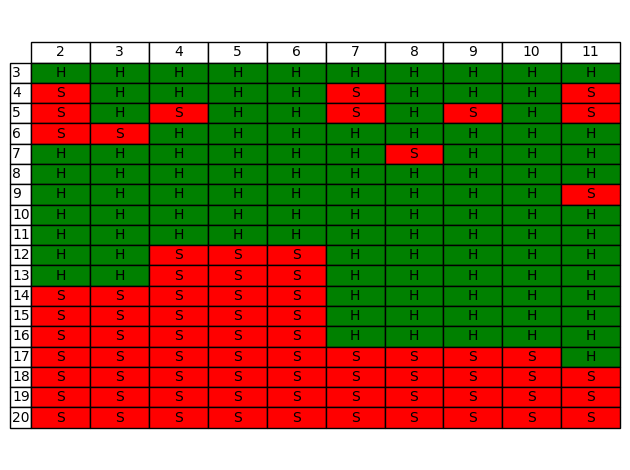

In [ ]:
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.set_axis_off()
ax.axis('tight')

ax.table(cellText=df.values, cellColours=color_df.values, cellLoc='center', rowLabels=df.index, colLabels=df.columns, loc='center')

fig.tight_layout()

plt.show()

# Test Best Policy on New Episodes

In [ ]:
env = BlackjackEnv()
NUM_EPISODES = 100000

for _ in range(NUM_EPISODES):
    state = env.reset()
    while env.done == False:
        if state[0] == 19:
            # Player was dealt with a Blackjack
            next_state, reward, env.done, info = env.step(1)
            total_rewards += reward
        else:
            Q_index = get_Q_state_index(state)
            action = new_Q_binary[Q_index]
            new_state, reward, done, desc = env.step(action)
            state = new_state
            total_rewards += reward
avg_reward = total_rewards / NUM_EPISODES
print(f'Average Reward: {avg_reward}')

Average Reward: -4.677


# Credits

The code is work of Mr. Adithya Solai.
<br>
The conversion from Python to Python Notebook is work of Mr. Sushant Nair.
<br>
The inspiration for making this Python Notebook as part of the RL Series is Mr. Terrence Ou
<br>
The code is further explained in the following Medium articles by Mr. Adithya Solai. GitHub Repo link is also provided.
<br>
1.	https://towardsdatascience.com/cracking-blackjack-part-1-31da28aeb4bb
2.	https://towardsdatascience.com/cracking-blackjack-part-2-75e32363e38
3.	https://towardsdatascience.com/cracking-blackjack-part-3-8fd3a5870efd
4.	https://towardsdatascience.com/cracking-blackjack-part-4-8b4a9caa38eb
5.	https://towardsdatascience.com/cracking-blackjack-part-5-70bd2f726133

https://github.com/adithyasolai/Monte-Carlo-Blackjack/blob/master/MC_Blackjack_Full.ipynb
